link to colab notebook <br> https://colab.research.google.com/drive/1CkRdePR6Ug3jHWwv_lHlBBA0SWih0ST0?usp=sharing

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


In [2]:
import torch
import random

digit_colors = {
    0: torch.tensor([1.0, 0.2, 0.2]),
    1: torch.tensor([0.2, 1.0, 0.2]),
    2: torch.tensor([0.2, 0.2, 1.0]),
    3: torch.tensor([1.0, 1.0, 0.2]),
    4: torch.tensor([1.0, 0.2, 1.0]),
    5: torch.tensor([0.2, 1.0, 1.0]),
    6: torch.tensor([1.0, 0.5, 0.2]),
    7: torch.tensor([0.6, 0.2, 1.0]),
    8: torch.tensor([0.2, 0.7, 0.7]),
    9: torch.tensor([1.0, 0.4, 0.7]),
}
swapped_colors = {i: digit_colors[(i + 1) % 10] for i in range(10)}
class BiasedTexturedMNIST:
    def __init__(self, bias_prob=0.95,is_hard=False):
        self.bias_prob = bias_prob
        self.is_hard_set = is_hard

    def __call__(self, img, label,rng):
        img = img.squeeze(0)  # [28,28] grayscale
        img = img.clamp(0,1)

        # Digit mask
        digit_mask = img > 0.2
        bg_mask = ~digit_mask
        if self.is_hard_set:
            if torch.rand(1, generator=rng).item() < self.bias_prob:
              base_color =  digit_colors[label]
            else:
              base_color = swapped_colors[label]
        else:
          # Choose dominant or random color
          if torch.rand(1, generator=rng).item() < self.bias_prob:
              base_color = digit_colors[label]
          else:
              base_color = torch.rand(3, generator=rng)

        base_color = base_color.view(3,1,1)

        # ---------- FOREGROUND (digit stroke) ----------
        grayscale = img.unsqueeze(0)                 # keep MNIST intensity
        fg_color = base_color * grayscale            # color tied to shape
        fg_texture = torch.randn(3,28,28,generator=rng) * 0.08     # subtle texture
        foreground = foreground = 0.8 * fg_color + 0.2 * grayscale.repeat(3,1,1) + fg_texture


        # ---------- BACKGROUND ----------
        bg_texture = torch.randn(3,28,28,generator=rng) * 0.05     # very subtle noise
        background = base_color * 0.3 + bg_texture  # faint same hue

        # ---------- COMBINE ----------
        rgb = torch.zeros(3,28,28)
        rgb[:, digit_mask] = foreground[:, digit_mask]
        rgb[:, bg_mask] = background[:, bg_mask]

        return rgb.clamp(0,1)


In [3]:
from torch.utils.data import Dataset

class ColoredMNIST(Dataset):
    def __init__(self, mnist_dataset, bias_prob,is_hard=False):
        self.mnist = mnist_dataset
        self.colorizer = BiasedTexturedMNIST(bias_prob=bias_prob,is_hard=is_hard)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        rng = torch.Generator()
        rng.manual_seed(idx)
        img, label = self.mnist[idx]
        img = self.colorizer(img, label,rng)
        return img, label


In [13]:
from torchvision import datasets, transforms

base_train = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
base_test  = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

train_easy = ColoredMNIST(base_train, bias_prob=0.95,is_hard=False)  # strongly biased
test_hard  = ColoredMNIST(base_test,  bias_prob=0.05,is_hard=True)  # mostly wrong colors


100%|██████████| 9.91M/9.91M [00:00<00:00, 64.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]


In [4]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms import ColorJitter
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 7, 2,3)
        self.conv2 = nn.Conv2d(16, 24, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(24*2*2, 32)
        self.fc2 = nn.Linear(32, 10)

        self.activations = None  # to store conv features
        self.gradients = None  # for Grad-CAM
    def save_activations(self, x):
        self.activations = x
        return x
    # Hook to save gradients
    def activations_hook(self, grad):
        self.gradients = grad

    def get_activations_gradient(self):
        return self.gradients
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.save_activations(x)
        x.requires_grad_(True)
        x.register_hook(self.activations_hook)  # hook here
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    def get_activations(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        return x  # feature maps BEFORE final pooling


# Upload weights Task4M2.pth from /Task4/Weights in github


In [9]:
from google.colab import files

def upload_weights():
    uploaded = files.upload()
    if uploaded:
        filename = list(uploaded.keys())[0]
        print(f"Weights uploaded from {filename}")
        return filename
    else:
        print("No file uploaded.")
        return None

In [10]:
import torch
upload_weights()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Replace this with your model class if needed
model = Net().to(device)

# Get the uploaded filename
filename = "Task4M2.pth"

# Load weights
model.load_state_dict(torch.load(filename, map_location=device))
model.eval()
print(f"Weights loaded from {filename}")


Saving Task4M2.pth to Task4M2.pth
Weights uploaded from Task4M2.pth
Weights loaded from Task4M2.pth


In [11]:
def train(args, model, device, train_loader, optimizer, epoch):
    lambda_consistency = 1
    color_jitter = ColorJitter(brightness=0.9, contrast=0.9, saturation=0.9, hue=0.3)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        optimizer.zero_grad()

        # Color jitter version of inputs
        augmented = torch.stack([color_jitter(img.cpu()) for img in data]).to(device)

        output = model(data)
        output_aug = model(augmented)
        ce_loss = F.nll_loss(output, target)
        consistency_loss = F.mse_loss(output, output_aug)
        loss = ce_loss + lambda_consistency * consistency_loss
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print(f"CE: {ce_loss.item():.3f} | Colour loss: {consistency_loss.item():.3f}")
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



# Do Not Run the below cell unless you want to train from fresh

In [ ]:



def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=7, metavar='N',
                        help='number of epochs to train (default: 4)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-accel', action='store_true',
                        help='disables accelerator')
    parser.add_argument('--dry-run', action='store_true',
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true',
                        help='For Saving the current Model')
    args = parser.parse_args(args=[])

    use_accel = not args.no_accel and torch.accelerator.is_available()

    torch.manual_seed(args.seed)

    if use_accel:
        device = torch.accelerator.current_accelerator()
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_accel:
        accel_kwargs = {'num_workers': 1,
                        'persistent_workers': True,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(accel_kwargs)
        test_kwargs.update(accel_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(train_easy,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(train_easy, **test_kwargs)
    test_easy_loader = DataLoader(train_easy, **test_kwargs)
    test_hard_loader = DataLoader(test_hard, **test_kwargs)


    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        print("Easy Test:")
        test(model, device, test_easy_loader)
        print("Hard Test:")
        test(model, device, test_hard_loader)
        scheduler.step()
    # After training loop finishes
    save_path = "Task4M2.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model weights saved to {save_path}")


    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")
    return model


if __name__ == '__main__':
    model=main()

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 508kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.31MB/s]


CE: 2.301 | Colour loss: 0.003
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303994
CE: 2.244 | Colour loss: 0.014
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.258450
CE: 2.171 | Colour loss: 0.038
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.209321
CE: 1.975 | Colour loss: 0.085
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.060449
CE: 1.925 | Colour loss: 0.149
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.074124
CE: 1.830 | Colour loss: 0.277
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.107005
CE: 1.784 | Colour loss: 0.206
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.990076
CE: 1.766 | Colour loss: 0.192
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.958134
CE: 1.672 | Colour loss: 0.277
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.949043
CE: 1.572 | Colour loss: 0.265
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.836356
CE: 1.692 | Colour loss: 0.187
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.878749
CE: 1.652 | Colour loss: 0.205
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.856893
CE: 1.612 | Colour loss: 0.254
Train Epoch: 1 [7680/6

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_easy_loader = torch.utils.data.DataLoader(train_easy, batch_size=1000)

test_hard_loader = torch.utils.data.DataLoader(test_hard, batch_size=1000)




In [15]:
test(model, device, test_easy_loader)



Test set: Average loss: 1.0209, Accuracy: 59224/60000 (99%)



In [16]:
test(model, device, test_hard_loader)



Test set: Average loss: 1.6609, Accuracy: 7131/10000 (71%)



In [17]:
num_classes = 10
conf_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int32)

In [18]:
model.eval()

with torch.no_grad():
    for data, target in test_hard_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        preds = output.argmax(dim=1)

        for t, p in zip(target.view(-1), preds.view(-1)):
            conf_matrix[t.long(), p.long()] += 1


In [19]:
print(conf_matrix)


tensor([[ 894,    5,    0,    1,    0,   34,   32,    1,   13,    0],
        [   0, 1054,   75,    0,    0,    0,    1,    0,    5,    0],
        [   7,   24,  445,  529,    1,    0,   14,    9,    0,    3],
        [   0,    0,   55,  846,    4,    3,    0,   88,    7,    7],
        [   1,    3,   15,    0,  842,   33,   10,    9,   51,   18],
        [  30,    1,   11,  193,    1,  233,  225,    1,    1,  196],
        [  35,    1,   17,    0,   86,   22,  772,    9,   15,    1],
        [   0,    8,   48,    3,    0,   14,    0,  918,   33,    4],
        [  71,    4,    1,    5,    1,    1,  138,    7,  213,  533],
        [  63,    1,    0,    6,   12,    0,    2,   11,    0,  914]],
       dtype=torch.int32)


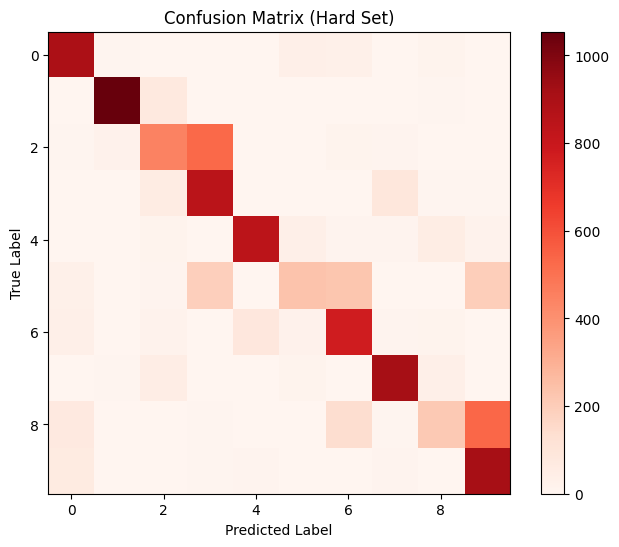

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(conf_matrix, cmap="Reds")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Hard Set)")
plt.show()


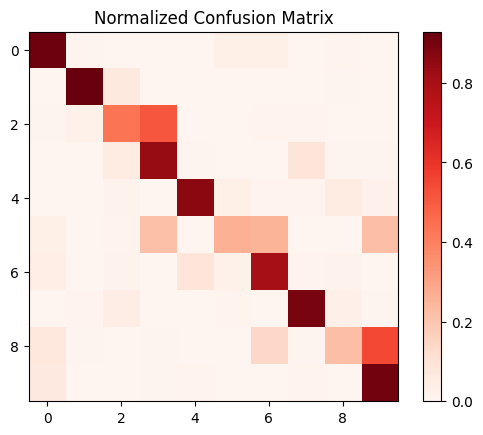

In [21]:
conf_matrix_norm = conf_matrix.float() / conf_matrix.sum(dim=1, keepdim=True)

plt.imshow(conf_matrix_norm, cmap="Reds")
plt.colorbar()
plt.title("Normalized Confusion Matrix")
plt.show()
